In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from os import listdir
import itertools
from Bio.Seq import Seq
import numpy as np
import logomaker

In [2]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='.',markersize=2)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

In [3]:
def list_files1(directory):
    return [f for f in listdir(directory) if ('.csv' in f) and ('0319' in f)]

In [4]:
path = 'AnalysisFiles/AverageFiles/'
filelist = list_files1(path)


In [5]:
filelist

['20230319_ctrl_averagedf.csv',
 '20230319_p595evo_averagedf.csv',
 '20230319_p595wlt_averagedf.csv']

## Analyse trinucleotide motifs for ABE8e, CBE4max and eAID in CjBE-Library

436


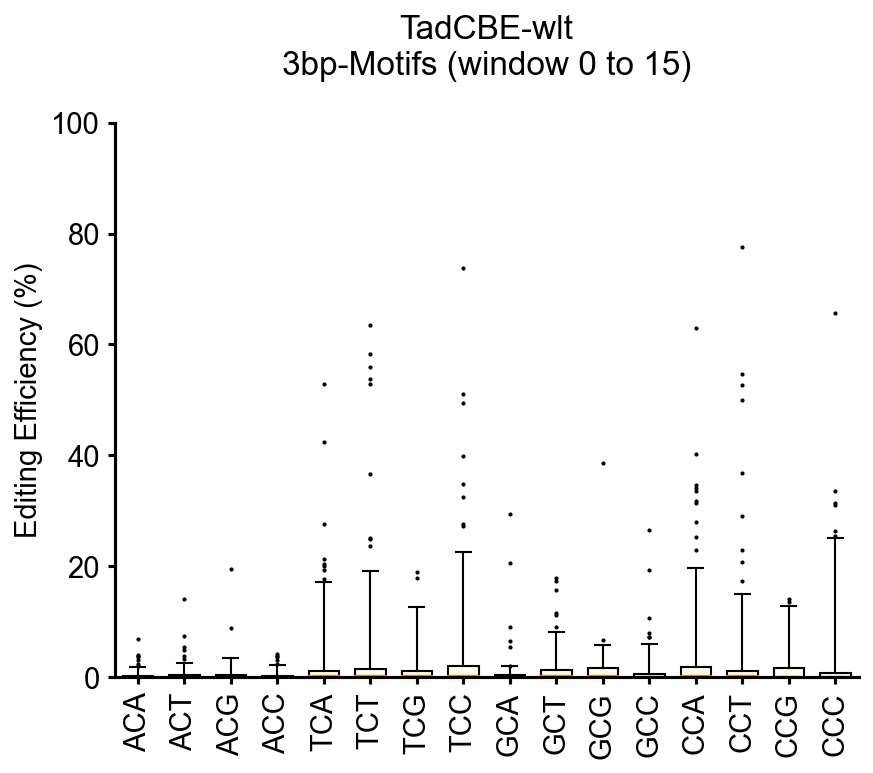

436


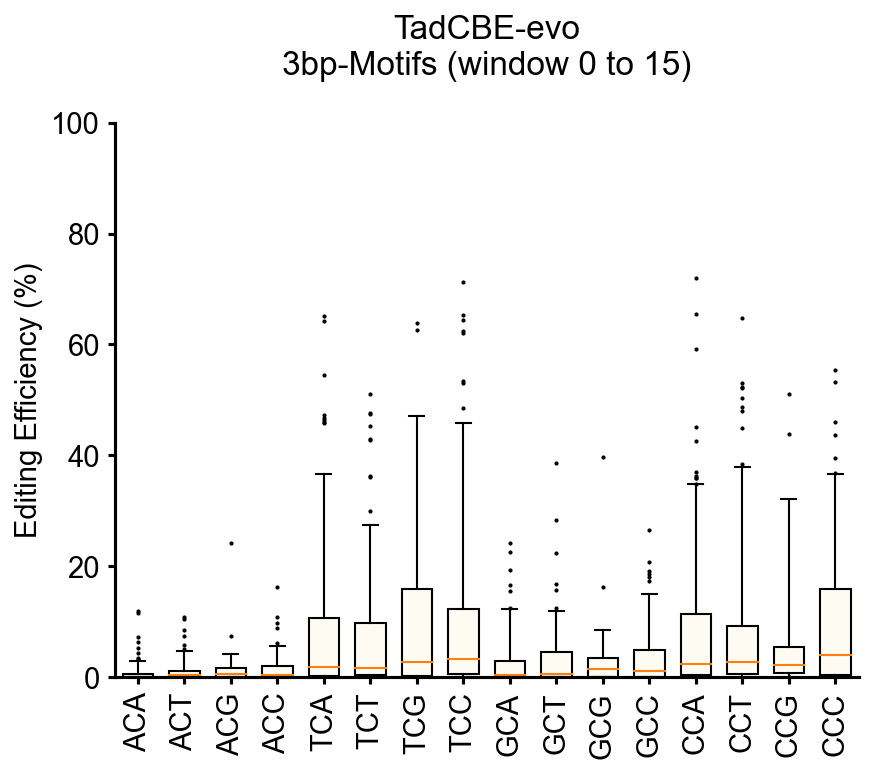

In [6]:
motifanalysislist = [('p595wlt','C','TadCBE-wlt',0,15),('p595evo','C','TadCBE-evo',0,15)]

for (editorshortname, base, editor, start, end) in motifanalysislist:
    
    # Define columnlist to check for editing efficiencies of respective base:
    if base == 'A':
        collist = [str(x)+'_AtoG_editing_average_ctrladjusted' for x in range(start,end+1)]
    if base == 'C':
        collist = [str(x)+'_CtoT_editing_average_ctrladjusted' for x in range(start,end+1)]
    
    df = pd.read_csv('AnalysisFiles/AverageFiles/20230319_'+editorshortname+'_averagedf.csv')
    df = df[df['Unnamed: 0.1'] > 0]  # only keep rows which do not have mismatches in protospacer etc. for this analysis
    df = df[df['percent_modified_average_ctrladjusted'] > -100]  # filter away all empty rows
    
    # protoplusseq corresponds to bases around spacer (-8-22) +/- one base to get 3bp motifs
    df['protoplusseq'] = df.apply(lambda x: str(Seq(x['Target-SequenceReady'][12+23-x['Protospacer_Length']+8-1:12+23-x['Protospacer_Length']+23+20]).reverse_complement()),axis=1)
    
    print(len(df))

    # Define all possible tri-nucleotide-motifs for A or C, depending on the base in the motifanalysislist:
    allpossiblemotiflist = []
    bases = ['A','T','G','C']
    for base1 in bases:
        for base3 in bases:
            allpossiblemotiflist.append(base1+base+base3)

    # Create empty dictionary with all tri-nucleotide-motifs
    allpossiblemotifdict = {}
    for motif in allpossiblemotiflist:
        allpossiblemotifdict[motif] = []
    
    # Fill dictionary with editing values for different motifs:
    for index, row in df.iterrows():
        for column in collist:
            editingvalue = df.at[index,column]
            if editingvalue < 0:  # cap editingvalues at zero after subtracting control (negative values are not possible for editing)
                editingvalue = 0
            if editingvalue > -100:  # only check for positions where there is a value (which means there is a target base at this position)
                position_within_protoplusseq = int(column.split('_')[0]) + 9
                trinucleotidemotif = row.protoplusseq[position_within_protoplusseq-1:position_within_protoplusseq+2]
                allpossiblemotifdict[trinucleotidemotif].append(editingvalue)

    
    # Save datapoints of dictionary in .csv file
    allpossiblemotifdf = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in allpossiblemotifdict.items() ]))
    allpossiblemotifdf.to_csv('AnalysisFiles/figures/20230321_'+editorshortname+'_'+editor+'_3bp-motif_datapoints.csv')
    
    
    # Create boxplot visualizing editing rates for each motif:
    motifboxplotlist = []
    for motif in list(allpossiblemotiflist):
        motifboxplotlist.append(allpossiblemotifdict[motif])
    fig11, ax11 = plt.subplots(dpi=150)
    ax11.set_title(editor+'\n3bp-Motifs (window '+str(start)+' to '+str(end)+')\n', fontsize=titlesize)
    ax11.boxplot(motifboxplotlist,**boxplot_kwargs, flierprops = flierprops)
    ax11.set_xticklabels(allpossiblemotiflist)
    ax11.set_ylabel('Editing Efficiency (%)', fontsize=lsize)
    ax11.tick_params(axis='x', labelsize= lsize, width=1.5)
    ax11.tick_params(axis='y', labelsize= lsize, width=1.5)
    ax11.spines['right'].set_visible(False)
    ax11.spines['top'].set_visible(False)
    ax11.tick_params(axis='x', labelrotation=90)
    ax11.set_ylim(0,100)
    figurepath = 'AnalysisFiles/figures/'
    plt.savefig(figurepath+'20230321_'+editorshortname+'_'+editor+'_3bp-motif_Boxplots.pdf', format='pdf',transparent=True,bbox_inches='tight')
    plt.show()

### Convert Average files into .csv files suitable for plotting of PAM splitted graphs

In [7]:
df

,Unnamed: 0,Unnamed: 0.1,Name,Gene,Phenotype,PAM,ABE pos,CBE pos,Sequence,Reverse-Complement,...,21_CtoT_editing_rep1_ctrladjusted,21_CtoT_editing_rep2_ctrladjusted,21_CtoT_editing_rep3_ctrladjusted,22_CtoT_editing_average_ctrladjusted,22_CtoT_editing_rep1_ctrladjusted,22_CtoT_editing_rep2_ctrladjusted,22_CtoT_editing_rep3_ctrladjusted,-9_AtoG_editing_average_ctrladjusted,percent_modified_average_ctrladjusted,protoplusseq
1,161.0,1,NM_004958.4(MTOR):c.6625C>G (p.Leu2209Val),MTOR,Metastatic pancreatic neuroendocrine tumours,TAAC,NaN,NaN,TACCTGAGGTTTTTCCGAAGAGATGTTGGGTCATTGGCCAGAAGGG...,TGAGCGTGTGATGCAGCTCTTCGGCCTGGTTAACACCCTTCTGGCC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.433227,TCCGAAGAGATGTTGGGTCATTGGCCACAAGGG
2,200.0,2,NM_005957.4(MTHFR):c.604C>A (p.Pro202Thr),MTHFR,Homocysteinemia due to MTHFR deficiency,TAAC,NaN,NaN,TTCAAGTGCTTCAGGTCAGCCTCAAAGCTCCCTGCTTCGGGGTGGC...,CTGACTGTCATCCCTATTGGCAGGTTACCCCAAAGGCCACCCCGAA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.405514,GCCTCAAAGCTCCCTGCTTCGGTGTGGCCTTTG
3,248.0,3,NM_014874.3(MFN2):c.703C>T (p.Gln235Ter),MFN2,"Charcot-Marie-Tooth disease, type 2",TAAC,NaN,NaN,TGTGTTTGTGCTGGTGGCCAACTCAGAGTCCACCCTGATGCAGACG...,GCTGGGAGCTTGGGAGAAGGCAGAGGAGGAGTTACCGTCTGCATCA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.858512,TGGTGGCCAACTCAGAGTCCACCCTGATGTAGA
4,347.0,4,NM_003000.2(SDHB):c.287-1G>C,SDHB,Gastrointestinal stroma tumor;Hereditary Parag...,TAAC,NaN,NaN,TTGCCTCCATTGATGTTCATTGCACAAGAGCCACAGATGCCTGAAA...,CGGATATGGGTGAGGATGTGTTAAATGTGTGTCTCTTTCAGGCATC...,...,-0.213595,-0.126377,-0.213595,NaN,NaN,NaN,NaN,NaN,-3.698918,CACAAGAGCCACAGATGCGTGAAAGAGACACAC
5,423.0,5,NM_000478.6(ALPL):c.620A>C (p.Gln207Pro),ALPL,Infantile hypophosphatasia;not provided,TAAC,NaN,NaN,CCTGAGGCCTTGAGCCAGGGCTGTAAGGACATCGCCTACCAGCTCA...,CCGAGCACTCACGTCAATGTCCCTGATGTTATGCATGAGCTGGTAG...,...,0.000000,0.198807,0.612245,NaN,NaN,NaN,NaN,NaN,73.499615,CCAGGGCTGTAAGGACATCGCCTACCCGCTCAT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,NaN,491,OTC_2,OTC,NaN,various,17.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.531836,TGAATGAAAGTCTCACAGACACCGCTCAGTTTG
492,NaN,492,OTC_3,OTC,NaN,various,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.872367,-0.792566,-0.691453,-1.133082,NaN,-0.300131,CAGACACCGCTCAGTTTGTAAAACTTTTCTTCC
493,NaN,493,Smn2_1,SMN2,NaN,various,11.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.809582,TCCTTCTTTTTGATTTTGTCTAAAACCCTGTAA
494,NaN,494,Eif2b5_1,Eif2b5,NaN,various,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.957955,AGTCGTCACCCAGCCACCCTACACACTGCCATG


In [20]:
savepath = 'AnalysisFiles/AverageFiles/PAMplotting/'

# create dataframe which will contain the number of spacers available in the buckets "canonical" and "noncanonical" for each editor
spacercountdf = pd.DataFrame()
namelist = []
canonicalnrlist = []
noncanonicalnrlist = []

for file in filelist:
    name = file.split('_')[1]
    df = pd.read_csv(path+file)

    #filter for self-targeting variants which can be used for following analysis (low coverage or mismatch protosopacers)
    removegenes = ['ALDH4A1','DYRK1A','?MECP2','?PTEN','?EMX1']
    df = df[~df['Gene'].isin(removegenes)]
    df = df[df['PAM'] != 'various']
    df = df[df['highcoveragereps'] == 3]
    df = df[df['controlhighcoveragereps'] == 3]
    
    pamuniquelist = list(df.PAM.unique())
    collist = list(df.columns)
    adjustlist = [x for x in collist if 'ctrladjust' in x]
    #adjustlist = [x for x in adjustlist if not 'average' in x]
    adjustlist = [x for x in adjustlist if 'average' in x]
    #adjustlist = [x for x in collist if not 'raw' in x]
    AtoGcolumns = [x for x in adjustlist if 'AtoG' in x]
    CtoTcolumns = [x for x in adjustlist if 'CtoT' in x]
    AtoG = False
    CtoT = False
    if '1_CtoT_editing_average_ctrladjusted' in adjustlist:
        CtoT = True
    if '1_AtoG_editing_average_ctrladjusted' in adjustlist:
        AtoG = True


    # calculate number of spacers that are used to quantify editing for each editor (excluding ctrl)
    if not 'ctrl' in file:
        namelist.append(name)
        
        canonical_pams = ['ACAC', 'ATAC', 'GTAC', 'GCAC']
        non_canonical_pams = ['AAAC', 'CAAC', 'GAAC', 'TAAC']

        # count how many rows have a canonical PAM in the 'PAM' column
        canonical_pam_count = df['PAM'].isin(canonical_pams).sum()
        non_canonical_pam_count = df['PAM'].isin(non_canonical_pams).sum()

        canonicalnrlist.append(canonical_pam_count)
        noncanonicalnrlist.append(non_canonical_pam_count)
        print(file)
        print('canonical PAMs: ', canonical_pam_count)
        print('non-canonical PAMs: ', non_canonical_pam_count)
        spacercountdf


    
        
    allPAMdfAtoG = pd.DataFrame()
    allPAMdfCtoT = pd.DataFrame()

    for PAM in pamuniquelist:
        if AtoG == True:
            PAMdf = df[df['PAM'] == PAM]
            PAMdf = PAMdf[AtoGcolumns]
            PAMdf = PAMdf.transpose()
            # clip all numeric values (excluding NaN) below 0 to zero:
            num = PAMdf._get_numeric_data()
            num[num < 0] = 0
            
            colnr = len(PAMdf.columns)
            for x in range(51-colnr):
                PAMdf['empty'+str(x)] = None
            PAMdf = PAMdf.add_prefix(PAM+'_')
            allPAMdfAtoG = pd.concat([allPAMdfAtoG, PAMdf], axis=1)
            #allPAMdfAtoG = allPAMdfAtoG.transpose()
            allPAMdfAtoG.to_csv(savepath+'20230321_'+name+'_allPAMdfAtoG.csv')
        if CtoT == True:
            PAMdf = df[df['PAM'] == PAM]
            PAMdf = PAMdf[CtoTcolumns]
            PAMdf = PAMdf.transpose()
            # clip all numeric values (excluding NaN) below 0 to zero:
            num = PAMdf._get_numeric_data()
            num[num < 0] = 0
            
            colnr = len(PAMdf.columns)
            for x in range(51-colnr):
                PAMdf['empty'+str(x)] = None
            PAMdf = PAMdf.add_prefix(PAM+'_')
            allPAMdfCtoT = pd.concat([allPAMdfCtoT, PAMdf], axis=1)
            #allPAMdfCtoT = allPAMdfCtoT.transpose()
            allPAMdfCtoT.to_csv(savepath+'20230321_'+name+'_allPAMdfCtoT.csv')

spacercountdf['editor'] = namelist
spacercountdf['nr_of_canonical_spacers_analyzed'] = canonicalnrlist
spacercountdf['nr_of_noncanonical_spacers_analyzed'] = noncanonicalnrlist
averagepath = 'AnalysisFiles/AverageFiles/'
spacercountdf.to_csv(averagepath+'20230504_spacercount_canonical_non_canonical_TadCBE.csv')

20230319_p595evo_averagedf.csv
canonical PAMs:  146
non-canonical PAMs:  162
20230319_p595wlt_averagedf.csv
canonical PAMs:  144
non-canonical PAMs:  160


In [14]:
df

,Unnamed: 0,Unnamed: 0.1,Name,Gene,Phenotype,PAM,ABE pos,CBE pos,Sequence,Reverse-Complement,...,21_CtoT_editing_average_ctrladjusted,21_CtoT_editing_rep1_ctrladjusted,21_CtoT_editing_rep2_ctrladjusted,21_CtoT_editing_rep3_ctrladjusted,22_CtoT_editing_average_ctrladjusted,22_CtoT_editing_rep1_ctrladjusted,22_CtoT_editing_rep2_ctrladjusted,22_CtoT_editing_rep3_ctrladjusted,-9_AtoG_editing_average_ctrladjusted,percent_modified_average_ctrladjusted
1,161.0,1,NM_004958.4(MTOR):c.6625C>G (p.Leu2209Val),MTOR,Metastatic pancreatic neuroendocrine tumours,TAAC,NaN,NaN,TACCTGAGGTTTTTCCGAAGAGATGTTGGGTCATTGGCCAGAAGGG...,TGAGCGTGTGATGCAGCTCTTCGGCCTGGTTAACACCCTTCTGGCC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.054320
2,200.0,2,NM_005957.4(MTHFR):c.604C>A (p.Pro202Thr),MTHFR,Homocysteinemia due to MTHFR deficiency,TAAC,NaN,NaN,TTCAAGTGCTTCAGGTCAGCCTCAAAGCTCCCTGCTTCGGGGTGGC...,CTGACTGTCATCCCTATTGGCAGGTTACCCCAAAGGCCACCCCGAA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.362276
3,248.0,3,NM_014874.3(MFN2):c.703C>T (p.Gln235Ter),MFN2,"Charcot-Marie-Tooth disease, type 2",TAAC,NaN,NaN,TGTGTTTGTGCTGGTGGCCAACTCAGAGTCCACCCTGATGCAGACG...,GCTGGGAGCTTGGGAGAAGGCAGAGGAGGAGTTACCGTCTGCATCA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.812256
4,347.0,4,NM_003000.2(SDHB):c.287-1G>C,SDHB,Gastrointestinal stroma tumor;Hereditary Parag...,TAAC,NaN,NaN,TTGCCTCCATTGATGTTCATTGCACAAGAGCCACAGATGCCTGAAA...,CGGATATGGGTGAGGATGTGTTAAATGTGTGTCTCTTTCAGGCATC...,...,-0.117120,0.075831,-0.213595,-0.213595,NaN,NaN,NaN,NaN,NaN,-2.577177
5,423.0,5,NM_000478.6(ALPL):c.620A>C (p.Gln207Pro),ALPL,Infantile hypophosphatasia;not provided,TAAC,NaN,NaN,CCTGAGGCCTTGAGCCAGGGCTGTAAGGACATCGCCTACCAGCTCA...,CCGAGCACTCACGTCAATGTCCCTGATGTTATGCATGAGCTGGTAG...,...,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,3.302260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,10501.0,462,NM_020800.3(IFT80):c.2101G>C (p.Ala701Pro),IFT80,Asphyxiating thoracic dystrophy 2,AAAC,NaN,NaN,GTATCAACATGTGTTTTGTATTTTACAGCCAATTCCAGTGCCCTAT...,ACAAACAATGTTAATAATCTGTTTTATTTCTCATTATAGGGCACTG...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.132490
463,10523.0,463,NM_000055.4(BCHE):c.1183G>T (p.Glu395Ter),BCHE,Deficiency of butyrylcholine esterase,AAAC,NaN,NaN,TGATCATCTACCCAGTCTGTGTAATGAAAAAGGATGGATTCCTTTC...,TTTAAAAATATTTTTTCCAGGAGTGAGTGAGTTTGGAAAGGAATCC...,...,-0.257211,-1.114444,-1.129867,1.472679,NaN,NaN,NaN,NaN,NaN,-1.618047
464,10540.0,464,NM_007217.4(PDCD10):c.395+2T>G,PDCD10,not provided,AAAC,NaN,NaN,GTACTTTTAAGAAAAGAAGAAACAAAACAAATAATTGCTTACTTGA...,TGAGATCAATGACAGAGTGAGGTTTCTGCAGACAATCAAGTAAGCA...,...,0.028324,-0.776373,-0.455137,1.316481,NaN,NaN,NaN,NaN,NaN,0.075670
465,10550.0,465,NM_005025.4(SERPINI1):c.1174G>A (p.Gly392Arg),SERPINI1,"Encephalopathy, familial, with neuroserpin inc...",AAAC,NaN,NaN,TGTTTACTTCTGAACCAATACAGGTACAATTCTATTCATGGGACGA...,TGTCCACTTGTGTTCATTGTTTCAGGATGCATGACTCGTCCCATGA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.957940


In [11]:
allPAMdfCtoTlist = ['20230321_p595wlt_allPAMdfCtoT.csv', '20230321_p595evo_allPAMdfCtoT.csv']
for file in allPAMdfCtoTlist:
    df = pd.read_csv(savepath+file)
    df = df.set_index("Unnamed: 0")
    editor = file.split('_')[1]

    # Separate canonical and non-canonical PAMs
    canonical_pams = ['ACAC', 'ATAC', 'GTAC', 'GCAC']
    non_canonical_pams = ['AAAC', 'CAAC', 'GAAC', 'TAAC']

    # Filter columns for canonical and non-canonical PAMs
    canonical_columns = [col for col in df.columns if any(pam in col for pam in canonical_pams)]
    non_canonical_columns = [col for col in df.columns if any(pam in col for pam in non_canonical_pams)]



    # Calculate average editing, standard deviation and number of cells with a value
    result = []

    for i, row in df.iterrows():
        canonical_values = row[canonical_columns].dropna().astype(float)
        non_canonical_values = row[non_canonical_columns].dropna().astype(float)

        canonical_mean = canonical_values.mean()
        non_canonical_mean = non_canonical_values.mean()

        canonical_std = canonical_values.std()
        non_canonical_std = non_canonical_values.std()

        canonical_n = len(canonical_values)
        non_canonical_n = len(non_canonical_values)

        result.append({
            'position': i,
            'canonical_mean': canonical_mean,
            'canonical_n': canonical_n,
            'canonical_std': canonical_std,
            'non_canonical_mean': non_canonical_mean,
            'non_canonical_std': non_canonical_std,
            'non_canonical_n': non_canonical_n
        })

    result_df = pd.DataFrame(result)
    result_df.to_csv(savepath+'20230501_'+editor+'_allPAMdfCtoT_newformat.csv', index=False)

In [12]:
df

,TAAC_1,TAAC_2,TAAC_3,TAAC_4,TAAC_5,TAAC_6,TAAC_7,TAAC_8,TAAC_9,TAAC_10,...,AAAC_465,AAAC_466,AAAC_467,AAAC_empty0,AAAC_empty1,AAAC_empty2,AAAC_empty3,AAAC_empty4,AAAC_empty5,AAAC_empty6
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
-9_CtoT_editing_average_ctrladjusted,NaN,NaN,NaN,0.000000,0.350140,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-8_CtoT_editing_average_ctrladjusted,0.000000,0.000000,NaN,NaN,0.070028,NaN,NaN,NaN,0.000000,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-7_CtoT_editing_average_ctrladjusted,0.000000,0.000000,NaN,0.029011,NaN,0.000000,NaN,NaN,NaN,NaN,...,NaN,0.000000,0.676538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6_CtoT_editing_average_ctrladjusted,NaN,NaN,NaN,NaN,NaN,0.239552,0.065876,0.000000,NaN,NaN,...,0.156250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5_CtoT_editing_average_ctrladjusted,NaN,0.000000,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4_CtoT_editing_average_ctrladjusted,NaN,NaN,NaN,NaN,NaN,0.374374,0.288489,NaN,0.000000,NaN,...,NaN,NaN,0.515599,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3_CtoT_editing_average_ctrladjusted,NaN,NaN,0.112526,NaN,0.140056,NaN,0.000000,NaN,NaN,0.351758,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2_CtoT_editing_average_ctrladjusted,NaN,NaN,0.000000,NaN,NaN,NaN,0.401253,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1_CtoT_editing_average_ctrladjusted,NaN,NaN,NaN,0.000000,NaN,0.670179,NaN,NaN,NaN,NaN,...,7.734162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
savepath = 'AnalysisFiles/AverageFiles/PAMplotting/'

for file in filelist:
    name = file.split('_')[1]
    print(name)
    df = pd.read_csv(path+file)

    #filter for self-targeting variants which can be used for following analysis (low coverage or mismatch protosopacers)
    removegenes = ['ALDH4A1','DYRK1A','?MECP2','?PTEN','?EMX1']
    df = df[~df['Gene'].isin(removegenes)]
    df = df[df['PAM'] != 'various']
    df = df[df['highcoveragereps'] == 3]
    df = df[df['controlhighcoveragereps'] == 3]
    
    pamuniquelist = list(df.PAM.unique())
    collist = list(df.columns)
    adjustlist = [x for x in collist if 'adjust' in x]
    adjustlist = [x for x in collist if 'average' in x]
    AtoGcolumns = [x for x in adjustlist if 'AtoG' in x]
    CtoTcolumns = [x for x in adjustlist if 'CtoT' in x]
    AtoGcolumnlist = []
    CtoTcolumnlist = []
    for PAM in pamuniquelist:
        for col in ['AtoG_editing_rep1_ctrladjusted',
     'AtoG_editing_rep2_ctrladjusted',
     'AtoG_editing_rep3_ctrladjusted']:
            AtoGcolumnlist.append(PAM+'_'+col)
        for col in ['CtoT_editing_rep1_ctrladjusted',
     'CtoT_editing_rep2_ctrladjusted',
     'CtoT_editing_rep3_ctrladjusted']:
            CtoTcolumnlist.append(PAM+'_'+col)
    
    CtoT = False
    AtoG = False
    if '1_CtoT_editing_average_ctrladjusted' in adjustlist:
        CtoT = True
    if '1_AtoG_editing_average_ctrladjusted' in adjustlist:
        AtoG = True
    
    AtoGtempdf = pd.DataFrame(columns = AtoGcolumnlist, index=range(-9,23))
    CtoTtempdf = pd.DataFrame(columns = CtoTcolumnlist, index=range(-9,23))
    
    #allPAMdfAtoG = pd.DataFrame()
    #allPAMdfCtoT = pd.DataFrame()

    for position in range(-9,23):
        if AtoG == True:
            for col in AtoGcolumnlist:
                PAM = col[:4]
                value = df[df['PAM'] == PAM][str(position)+'_'+col[5:]].mean()
                #print(position, PAM, col, value)
                if value < 0:
                    value = 0
                        
                AtoGtempdf.at[position,col] = value
                
            AtoGtempdf.to_csv(savepath+'20230321_'+name+'_allreps_AtoG.csv')
        
        if CtoT == True:
            for col in CtoTcolumnlist:
                PAM = col[:4]
                value = df[df['PAM'] == PAM][str(position)+'_'+col[5:]].mean()
                #print(position, PAM, col, value)
                if value < 0:
                    value = 0
                        
                CtoTtempdf.at[position,col] = value
                
            CtoTtempdf.to_csv(savepath+'20230321_'+name+'_allreps_CtoT.csv')

ctrl
p595evo
p595wlt
